# PROGETTO: Web Scraping - Immobiliare.it

L'obiettivo di questo progetto è ottenere una buona estrazione dei dati degli annunci presenti sul sito Immobiliare.it (https://www.immobiliare.it/), tramite la costruzione di una funzione che consenta di fare Web Scraping dei suddetti dati. Infine, costruire un modello di ML che consente di prevedere il prezzo degli immoboli.

N.B. La parte di data cleaning e quella del modello di regressione lineare sono da perfezionare.

-----

Importo le Librerie

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

## DATA SCRAPING

### Estrazione dati

Creo una funzione che mi ritorna un df in base alla città e alla zona

In [ ]:
def scraping_immobiliare(city, zone):
    #fissiamo la città e la zona oggetto di ricerca per case in vendita
    città = city
    zona = zone
    url_search = "https://www.immobiliare.it/vendita-case/" + città + "/" + zona + "/?criterio=rilevanza"

    #otteniamo il numero di pagine risultati dalla ricerca prefissata
    url = url_search
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    #quando la ricerca produce un ultimo numero di pagine che è successivo a '...' prendi il valore con if, altrimenti prendi il valore con else
    #serve a prendere il numero di pagine correttamente
    if soup.find("div", class_="in-pagination__list").find_all("div", class_="in-pagination__item hideOnMobile in-pagination__item--disabled") != []:
        results = soup.find("div", class_="in-pagination__list").find_all("div", class_="in-pagination__item hideOnMobile in-pagination__item--disabled")
        n_pages = int(results[-1].text)
    else:
        results = soup.find("div", class_="in-pagination__list").find_all("a")
        n_pages = int(results[-1].text)

    #Creiamo una lista contente l'id di ogni annuncio
    id_annunci = []
    for page in range(1,n_pages+1):
        url = url_search + '&pag=' + str(page)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        results = soup.find_all("li", class_="nd-list__item in-realEstateResults__item")
        for id in results: 
            id_annunci.append(id.attrs.get('id'))

        titles = []
        prices = []
        locali = []
        superficie = []
        bagni = []
        piano = []

    #per ogni annuncio, estraggo i dati e poi li aggiugno alla rispettiva lista
    for page in range(1,n_pages+1):
        url = url_search + '&pag=' + str(page)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        for ad in id_annunci:
            results = soup.find(id=ad)
            if type(results) != type(None):
                try:
                    results_titles = results.find("a", class_="in-card__title")
                    titles.append(results_titles.text.strip())
                except:
                    titles.append(None)
                try:
                    results_prices = results.find("li", class_="nd-list__item in-feat__item in-feat__item--main in-realEstateListCard__features--main")
                    prices.append(results_prices.text.strip())
                except:
                    prices.append(None)
                try:
                    results_superficie = results.find("li", {"aria-label" : "superficie"})
                    superficie.append(results_superficie.text.strip())
                except:
                    superficie.append(None)
                try:
                    results_locali = results.find("li", {"aria-label" : ["locale", "locali"]})
                    locali.append(results_locali.text.strip())
                except:
                    locali.append(None)
                try:
                    results_bagni = results.find("li", {"aria-label" : ["bagno", "bagni"]})
                    bagni.append(results_bagni.text.strip())
                except:
                    bagni.append(None)
                try:
                    results_piano = results.find("li", {"aria-label" : ["piano", "piani"]})
                    piano.append(results_piano.text.strip())
                except:
                    piano.append(None)
            else:
                continue         
    
    df_tmp = pd.DataFrame({
                                    'title': titles, #titolo annuncio
                                     'città': città,
                                     'zona': zona,
                                     'prezzo': prices,
                                     'superfice': superficie,
                                     'piani': piano,
                                     'locali': locali,
                                     'bagni': bagni
                                     })

    return  df_tmp

Utilizzo la funzione sopra per creare un unico df contente i dati di varie zone di una città

In [ ]:
list_zone = ['fuorigrotta', 'bagnoli', 'chiaia', 'marechiaro', 'posillipo', 'vomero', 'pianura', 'soccavo', 'centro-direzionale']

In [ ]:
df_immobiliare_raw = pd.DataFrame()

for c in list_zone:
    df_tmp = scraping_immobiliare('napoli', c)
    df_immobiliare_raw = pd.concat([df_immobiliare_raw, df_tmp])

df_immobiliare_raw.index = pd.RangeIndex(len(df_immobiliare_raw.index)) # re-index df per evitare duplicati nell'indice

In [ ]:
df_immobiliare_raw.head()

,title,città,zona,prezzo,superfice,piani,locali,bagni
0,"Appartamento via Alessandro Manzoni, Posillipo...",napoli,fuorigrotta,€ 1.450.000,263m²,5,5+,3
1,"Trilocale via Giambattista Marino, Fuorigrotta...",napoli,fuorigrotta,€ 330.000,100m²,1,3,1
2,"Trilocale via Terracina, Fuorigrotta, Napoli",napoli,fuorigrotta,€ 175.000,90m²,T,3,1
3,Appartamento via Michelangelo da Caravaggio 11...,napoli,fuorigrotta,€ 850.000,200m²,T,5+,3
4,"Bilocale viale di Augusto, Fuorigrotta, Napoli",napoli,fuorigrotta,€ 235.000,60m²,5,2,2


## DATA CLEANING

In [ ]:
df_immobiliare_clean = df_immobiliare_raw.copy()

In [ ]:

df_immobiliare_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2137 non-null   object
 1   città      2137 non-null   object
 2   zona       2137 non-null   object
 3   prezzo     2063 non-null   object
 4   superfice  2128 non-null   object
 5   piani      1972 non-null   object
 6   locali     2112 non-null   object
 7   bagni      1905 non-null   object
dtypes: object(8)
memory usage: 133.7+ KB


Data cleaning delle colonne prezzo e superfice, bisogna: 
- pulire i dati nelle colonne prezzo e superfice
- sostituire i None
- modificare il data type
- pulire i dati nelle colonna bagni, locali, piani

###1.Pulisco i valori nelle colonne prezzo e superficie

In [ ]:
#definisco una funzione per sostituire elementi all'interno dei valori di una colonna
def clean_function(col, find, replace): 
    return col.str.replace(find, replace, regex=False)

In [ ]:
#Elimino '€', e 'm²' nei valori della colonna 'prezzo' e 'superficie
df_immobiliare_clean['prezzo'] = clean_function(df_immobiliare_clean['prezzo'],'€', '')
df_immobiliare_clean['superfice'] = clean_function(df_immobiliare_clean['superfice'],'m²', '')

In [ ]:
#rinomino le colonne indicando l'unità di misura
df_immobiliare_clean = df_immobiliare_clean.rename(columns={'prezzo':'prezzo(€)','superfice':'superficie(m²)'})

In [ ]:
df_immobiliare_clean.columns

Index(['title', 'città', 'zona', 'prezzo(€)', 'superficie(m²)', 'piani',
       'locali', 'bagni'],
      dtype='object')

In [ ]:
#lista degli indici delle righe con il prezzo d'asta
index_prezzo_aste = df_immobiliare_clean[df_immobiliare_clean['prezzo(€)'].str.contains('da')==True].index

In [ ]:
#sostituisco i prezzi d'asta con none, per poi dopo sostituirli con la media della zona
df_immobiliare_clean.loc[index_prezzo_aste, 'prezzo(€)'] = None

In [ ]:
#lista degli indici delle righe con il prezzo scontato
index_prezzo_discount = df_immobiliare_clean[df_immobiliare_clean['prezzo(€)'].str.contains('%')==True].index

In [ ]:
#sostituisco i prezzi scontati con il solo prezzo scontato
for i in list(range(0,len(index_prezzo_discount))):
    df_immobiliare_clean.loc[index_prezzo_discount[i], 'prezzo(€)'] = df_immobiliare_clean.loc[index_prezzo_discount[i], 'prezzo(€)'].split()[0]

In [ ]:
#Elimino '.' nella colonna 'prezzo'
df_immobiliare_clean['prezzo(€)'] = clean_function(df_immobiliare_clean['prezzo(€)'],'.', '')


###2.Sostituisco i valori None con la media della zona per il prezzo e le superficie

In [ ]:
#Converto in int i valori non null nella colonna prezzo
df_immobiliare_clean.loc[df_immobiliare_clean[df_immobiliare_clean['prezzo(€)'].notnull()]['prezzo(€)'].index, 'prezzo(€)'] = df_immobiliare_clean.loc[df_immobiliare_clean[df_immobiliare_clean['prezzo(€)'].notnull()]['prezzo(€)'].index, 'prezzo(€)'].astype('int')

In [ ]:
#definisco come calcolare la media per una zona
df_immobiliare_clean[(df_immobiliare_clean['zona']=='bagnoli') & (df_immobiliare_clean['prezzo(€)'].notnull())]['prezzo(€)'].mean()

266882.99319727893

In [ ]:
#sostituisco i valori None nella colonna prezzo con la media di ogni zona
for c in list_zone:
    m = df_immobiliare_clean[(df_immobiliare_clean['zona']==c) & (df_immobiliare_clean['prezzo(€)'].notnull())]['prezzo(€)'].mean()
    i = df_immobiliare_clean[(df_immobiliare_clean['zona']==c) & (df_immobiliare_clean['prezzo(€)'].isnull())]['prezzo(€)'].index
    df_immobiliare_clean.loc[i,'prezzo(€)'] = df_immobiliare_clean.loc[i,'prezzo(€)'].fillna(m)

In [ ]:
df_immobiliare_clean[df_immobiliare_clean['prezzo(€)'].isnull()]

,title,città,zona,prezzo(€),superficie(m²),piani,locali,bagni


In [ ]:
#Elimino '.' nella colonna 'superifice'
df_immobiliare_clean['superficie(m²)'] = clean_function(df_immobiliare_clean['superficie(m²)'],'.', '')

In [ ]:
#Converto in int i valori non null nella colonna superfice
df_immobiliare_clean.loc[df_immobiliare_clean[df_immobiliare_clean['superficie(m²)'].notnull()]['superficie(m²)'].index, 'superficie(m²)'] = df_immobiliare_clean.loc[df_immobiliare_clean[df_immobiliare_clean['superficie(m²)'].notnull()]['superficie(m²)'].index, 'superficie(m²)'].astype('int')

In [ ]:
#sostituisco i null nella colonna superfcie con la media di ogni zona
for c in list_zone:
    m = df_immobiliare_clean[(df_immobiliare_clean['zona']==c) & (df_immobiliare_clean['superficie(m²)'].notnull())]['superficie(m²)'].mean()
    i = df_immobiliare_clean[(df_immobiliare_clean['zona']==c) & (df_immobiliare_clean['superficie(m²)'].isnull())]['superficie(m²)'].index
    df_immobiliare_clean.loc[i,'superficie(m²)'] = df_immobiliare_clean.loc[i,'superficie(m²)'].fillna(m)

In [ ]:
df_immobiliare_clean[df_immobiliare_clean['superficie(m²)'].isnull()]

,title,città,zona,prezzo(€),superficie(m²),piani,locali,bagni


###3.Converto in 'int' i valori delle colonne prezzo e superficie

In [ ]:
df_immobiliare_clean['superficie(m²)'] = df_immobiliare_clean['superficie(m²)'].astype('int')
df_immobiliare_clean['prezzo(€)'] = df_immobiliare_clean['prezzo(€)'].astype('int')

In [ ]:
df_immobiliare_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           2137 non-null   object
 1   città           2137 non-null   object
 2   zona            2137 non-null   object
 3   prezzo(€)       2137 non-null   int64 
 4   superficie(m²)  2137 non-null   int64 
 5   piani           1972 non-null   object
 6   locali          2112 non-null   object
 7   bagni           1905 non-null   object
dtypes: int64(2), object(6)
memory usage: 133.7+ KB


###4.Pulisco i valori nelle colonne bagni, locali, piani

In [ ]:
df_immobiliare_clean['bagni'].unique()

array(['3', '1', '2', '3+', None], dtype=object)

In [ ]:
#Sostituisco '3+' con '4' e 'None' con zero, infine converto in 'int'
df_immobiliare_clean['bagni'] = clean_function(df_immobiliare_clean['bagni'],'3+', '4')
df_immobiliare_clean['bagni'] = df_immobiliare_clean['bagni'].fillna(0)
df_immobiliare_clean['bagni'] = df_immobiliare_clean['bagni'].astype('int')

In [ ]:
df_immobiliare_clean['locali'].unique()

array(['5+', '3', '2', '4', '5', '1', None], dtype=object)

In [ ]:
#Sostituisco '3+' con '4' e 'None' con zero, infine converto in 'int'
df_immobiliare_clean['locali'] = clean_function(df_immobiliare_clean['locali'],'5+', '6')
df_immobiliare_clean['locali'] = df_immobiliare_clean['locali'].fillna(0)
df_immobiliare_clean['locali'] = df_immobiliare_clean['locali'].astype('int')

In [ ]:
df_immobiliare_clean['piani'].unique()

array(['5', '1', 'T', '3', '4', '2', None, 'S2', 'R', '8', '7', '7 - 8',
       'S', '6', '3 - 4', '1 - 2', '4 - 5', '1 - 3', '5 - 6', '9',
       'T - R', 'S - T', '2 - 3', 'S3', 'A', '10', '14', '20', '12', '17',
       '21'], dtype=object)

In [ ]:
#Sostituisco '3+' con '4' e 'None' con zero, infine converto in 'int'
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'T', '0')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'R', '0')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'A', '0')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'0 - 0', '0')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'-1 - 0', '0')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'2 - 3', '0')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'S', '-1')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'S2', '-2')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'S3', '-3')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'7 - 8', '7')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'3 - 4', '3')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'1 - 2', '1')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'4 - 5', '4')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'1 - 3', '2')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'5 - 6', '5')
df_immobiliare_clean['piani'] = clean_function(df_immobiliare_clean['piani'],'S - T', '-1')
df_immobiliare_clean['piani'] = df_immobiliare_clean['piani'].fillna(0)
df_immobiliare_clean['piani'] = df_immobiliare_clean['piani'].astype('int')

In [ ]:
df_immobiliare_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           2137 non-null   object
 1   città           2137 non-null   object
 2   zona            2137 non-null   object
 3   prezzo(€)       2137 non-null   int64 
 4   superficie(m²)  2137 non-null   int64 
 5   piani           2137 non-null   int64 
 6   locali          2137 non-null   int64 
 7   bagni           2137 non-null   int64 
 8   rating          2137 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 150.4+ KB


##MODELLO DI REGRESSIONE LINEARE

###ANALISI CORRELLEZIONE

In [ ]:
df_immobiliare_clean.corr()

,prezzo(€),superficie(m²),piani,locali,bagni,rating
prezzo(€),1.000000,0.442037,-0.059408,0.506721,0.516082,0.382562
superficie(m²),0.442037,1.000000,-0.061817,0.155844,0.146364,0.040973
piani,-0.059408,-0.061817,1.000000,0.032271,-0.074950,-0.177564
locali,0.506721,0.155844,0.032271,1.000000,0.570322,0.279792
bagni,0.516082,0.146364,-0.074950,0.570322,1.000000,0.352420
rating,0.382562,0.040973,-0.177564,0.279792,0.352420,1.000000


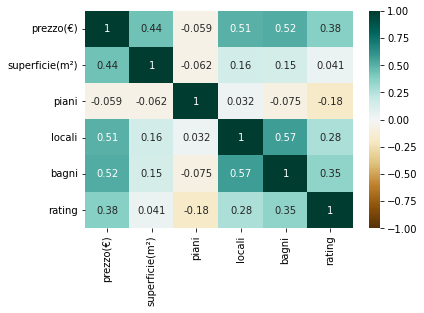

In [ ]:
sns.heatmap(df_immobiliare_clean.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

####Prezzo vs superificie

In [ ]:
#il prezzo dovrebbe aumentare al crescere della superficie

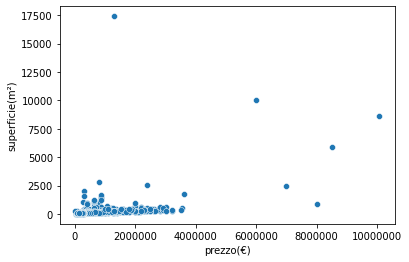

In [ ]:
sns.scatterplot(data=df_immobiliare_clean, x='prezzo(€)', y='superficie(m²)')
plt.ticklabel_format(style='plain', axis='x')

In [ ]:
#restingo il df
df_immobiliare_clean_1 = df_immobiliare_clean[(df_immobiliare_clean['prezzo(€)']<4500000) & (df_immobiliare_clean['superficie(m²)']<1000)]

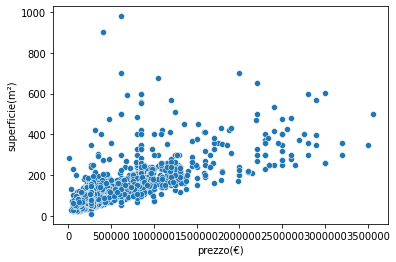

In [ ]:
sns.scatterplot(data=df_immobiliare_clean_1, x='prezzo(€)', y='superficie(m²)')
plt.ticklabel_format(style='plain', axis='x')

####Prezzo vs Zona

In [ ]:
#il prezzo dovrebbe aumentare al crescere del prestigio della zona

In [ ]:
#creo una nuova colonna rating
df_immobiliare_clean['rating'] = 0

#creo delle liste con le zone a cui assegno un rating in base all'esperienza personale
rating_1 =['pianura',  'soccavo',  'centro-direzionale']
rating_2 = ['fuorigrotta', 'bagnoli', 'vomero']
rating_3 = ['chiaia', 'marechiaro','posillipo']

In [ ]:
#assegno a ciascun record il rating in base alla zona
for c in list_zone:
    if c in rating_1:
        i = df_immobiliare_clean[df_immobiliare_clean['zona']==c].index
        df_immobiliare_clean.loc[i,'rating'] = 1
    elif c in rating_2:
        i = df_immobiliare_clean[df_immobiliare_clean['zona']==c].index
        df_immobiliare_clean.loc[i,'rating'] = 2
    else:
        i = df_immobiliare_clean[df_immobiliare_clean['zona']==c].index
        df_immobiliare_clean.loc[i,'rating'] = 3

In [ ]:
#verifico che in media le zona con un rating superiore hanno un prezzo maggiore
df_immobiliare_clean.groupby('rating', as_index=False)['prezzo(€)'].mean()

,rating,prezzo(€)
0,1,246764.814159
1,2,433180.921384
2,3,863568.105178


In [ ]:
#restingo il df
df_immobiliare_clean_2 = df_immobiliare_clean[(df_immobiliare_clean['prezzo(€)']<4500000) & (df_immobiliare_clean['superficie(m²)']<1000)]

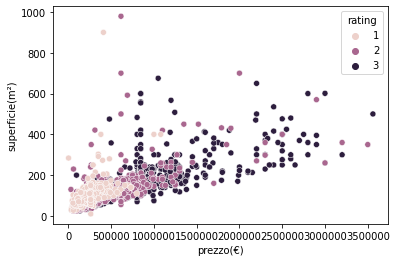

In [ ]:
sns.scatterplot(data=df_immobiliare_clean_2, x='prezzo(€)', y='superficie(m²)', hue='rating')
plt.ticklabel_format(style='plain', axis='x')

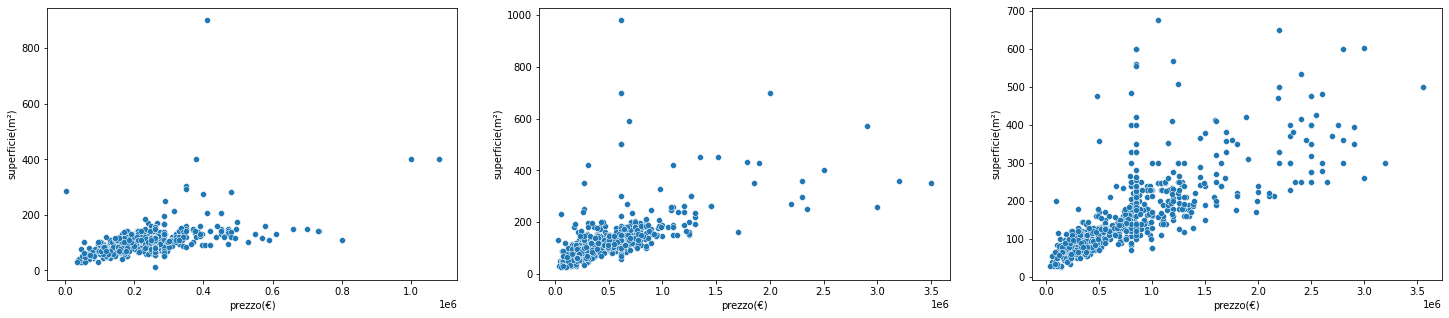

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(25, 5)

sns.scatterplot(data=df_immobiliare_clean_2[df_immobiliare_clean_2['rating']==1], x='prezzo(€)', y='superficie(m²)', ax = ax[0])
sns.scatterplot(data=df_immobiliare_clean_2[df_immobiliare_clean_2['rating']==2], x='prezzo(€)', y='superficie(m²)', ax = ax[1])
sns.scatterplot(data=df_immobiliare_clean_2[df_immobiliare_clean_2['rating']==3], x='prezzo(€)', y='superficie(m²)', ax = ax[2])

###REGRESSIONE SEMPLICE

In [ ]:
import statsmodels.api as sm

In [ ]:
#definiamo il modello
Y = df_immobiliare_clean_2['prezzo(€)']
X = df_immobiliare_clean_2['superficie(m²)']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prezzo(€)   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     2184.
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        09:25:40   Log-Likelihood:                -29884.
No. Observations:                2114   AIC:                         5.977e+04
Df Residuals:                    2112   BIC:                         5.978e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.347e+04   1.29e+04     -1.042      0.298   -3.88e+04    1.19e+04
superficie(m²)  3978.7932     85.142     46.731      0.000    3811.822    4145.765
==============================================================================
Omnibus:                      508.703   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23200.238
Skew:                           0.262   Prob(JB):                         0.00
Kurtosis:                      19.221   Cond. No.                         271.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#troviamo il prezzo di un appartamento di vari m² a napoli
print("Questo è il prezzo di un'appartamento di 80 m² a Napoli: Euro " + str(round(results.predict(np.array([1, 80]))[0],2)))
print("Questo è il prezzo di un'appartamento di 90 m² a Napoli: Euro " + str(round(results.predict(np.array([1, 90]))[0],2)))
print("Questo è il prezzo di un'appartamento di 100 m² a Napoli: Euro " + str(round(results.predict(np.array([1, 100]))[0],2)))
print("Questo è il prezzo di un'appartamento di 110 m² a Napoli: Euro " + str(round(results.predict(np.array([1, 110]))[0],2)))

Questo è il prezzo di un'appartamento di 80 m² a Napoli: Euro 304835.76
Questo è il prezzo di un'appartamento di 90 m² a Napoli: Euro 344623.69
Questo è il prezzo di un'appartamento di 100 m² a Napoli: Euro 384411.62
Questo è il prezzo di un'appartamento di 110 m² a Napoli: Euro 424199.56


###REGRESSIONE MULTIPLA

In [ ]:
y = df_immobiliare_clean_2['prezzo(€)']
X = df_immobiliare_clean_2[['superficie(m²)','piani', 'locali','bagni','rating']]
X = sm.add_constant(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prezzo(€)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     520.0
Date:                Sun, 12 Feb 2023   Prob (F-statistic):          7.34e-317
Time:                        09:23:41   Log-Likelihood:                -19820.
No. Observations:                1416   AIC:                         3.965e+04
Df Residuals:                    1410   BIC:                         3.968e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.044e+05   2.91e+04    -17.337      0.000   -5.61e+05   -4.47e+05
superficie(m²)  2656.9445    117.684     22.577      0.000    2426.089    2887.800
piani           8588.5016   3333.986      2.576      0.010    2048.395    1.51e+04
locali          4.786e+04   7253.526      6.598      0.000    3.36e+04    6.21e+04
bagni            8.48e+04   1.03e+04      8.223      0.000    6.46e+04    1.05e+05
rating          1.641e+05   1.13e+04     14.469      0.000    1.42e+05    1.86e+05
==============================================================================
Omnibus:                      409.425   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7729.364
Skew:                           0.853   Prob(JB):                         0.00
Kurtosis:                      14.318   Cond. No.                         604.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Mean Absolute Error (MAE)
def mae(y, pred): 
    return round(np.mean(np.abs(y - pred)), 2)

# Mean Absolute Percentage Error (MAPE)
def mape(y, pred): 
    return round(np.mean(np.abs((y - pred)/y))*100, 2)

# Root Mean Squared Error (RMSE)
def rmse(y, pred):
    return round(np.sqrt(np.mean((y - pred)**2)), 2)

In [ ]:
pred_train = results.predict(X_train)
pred_test = results.predict(X_test)

print('Training MAE:', mae(y_train, pred_train))
print('Testing MAE:', mae(y_test, pred_test))

print('Training MAPE:', mape(y_train, pred_train), '%')
print('Testing MAPE:', mape(y_test, pred_test), '%') 

print('Training RMSE:', rmse(y_train, pred_train))
print('Testing RMSE:', rmse(y_test, pred_test)) 

Training MAE: 178601.33
Testing MAE: 174155.72
Training MAPE: 50.52 %
Testing MAPE: 99.12 %
Training RMSE: 290094.82
Testing RMSE: 285492.62
